<h1>Bayesian GPLVM</h1>
Python 3.7.2<br>
Pytorch 1.0.1<br>
matplotlib 3.0.2<br>
jupyter 1.0.0<br>
jupyter lab 0.35.3<br></h4>

In [1]:
"Jupyter Lab Extension"
#%load_ext autoreload
#%autoreload 2
#%matplotlib ipympl

"패키지 불러오기"
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

from sklearn import datasets

print("CUDA Available :")
print(torch.cuda.is_available())

CUDA Available :
True


In [2]:
"데이터 생성"
data = torch.from_numpy(datasets.load_iris()['data'])[:50,:]
data.shape

torch.Size([50, 4])

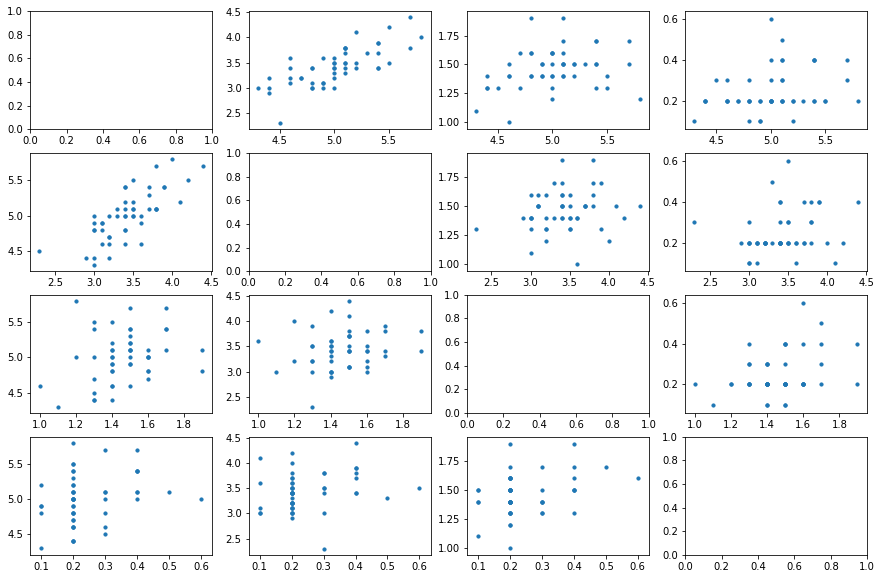

In [3]:
"생성된 데이터 시각화"
fig = plt.figure(figsize=(15,10))
for i in range(4):
    for j in range(4):
        fig.add_subplot(4, 4, 4 * i + j + 1)
        #plt.subplot(4, 4, 4 * i + j + 1)
        if i != j:
            plt.scatter(data[:,i].numpy(), data[:,j].numpy(), s=10)

plt.show()

In [4]:
class GP(nn.Module):
    def __init__(self, ndim_x, ndim_v):
        super(GP, self).__init__()
        "입력변수 및 목표변수 차원 지정"
        self.ndim_x = ndim_x
        self.ndim_v = ndim_v
        
        "GP 모델에 적합시킬 데이터 저장"
        self.data_x = torch.zeros(0, self.ndim_x)
        self.data_v = torch.zeros(0, self.ndim_v)
        
        "저장한 데이터에서 설명변수들을 가지고 L2 pairwise distance(Euclidean distance)를 구할 것"
        self.dist = torch.zeros((self.ndim_x, 0, 0))
        
        "Kernel Hyperparameter"
        self.KHP = nn.Conv2d(in_channels = self.ndim_x,
                             out_channels = 1,
                             kernel_size = (1,1),
                             bias = False)
        
        "Scale Parameter"
        self.scale = nn.Conv2d(in_features = 1,
                              out_features = 1,
                              bias = False)
        
        "Noise Parameter"
        self.beta = nn.Linear(in_features = 1,
                              out_features = 1,
                              bias = False)
        

        "Parameter Initialization"
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, mean=1, std=0.5)
            if isinstance(m, nn.Linear):
                init.normal_(m.weight, mean=1, std=0.5)
    
    
    
    "새로운 데이터의 X값들 추가"
    def fit_x(self, x_new):
        self.data_x = torch.cat((self.data_x, x_new), 0)
        self.dist = self.distance(self.data_x)        
    
    "Distance Matrix 계산 함수"
    def distance(self, data_x):
        N = data_x.shape[0]
        D = data_x.shape[1]
        dist = torch.zeros(D, N, N)
        for dim in range(D):
            term1 = (data_x[:, dim] ** 2).expand((N,N))
            term2 = data_x[:, dim].unsqueeze(0).transpose(0, 1) * data_x[:, dim].unsqueeze(0)
            dist[dim] = (term1 + term1.transpose(0,1) - 2 * term2).unsqueeze(0)
        return dist
    
    "Scale 행렬 계산 함수"
    "Softplus activation function으로 정규분포 분산을 모수화(범위를 양수로 제한, 학습 안정화)"   
    def scale(self, dim):
        return F.softplus(self.scale(torch.ones((self.ndim_x, self.ndim_x))))
    
    "Noise 행렬 계산 함수"
    "Softplus activation function으로 정규분포 분산을 모수화(범위를 양수로 제한, 학습 안정화)"   
    def noise(self, dim):
        return F.softplus(self.beta(torch.ones(1))) * torch.eye(dim)
    
    "Pytorch에서 학습을 시키기 위해 꼭 필요한 forward Method"
    "적절한 Kernel 계산을 위해 maximum cliping"
    def forward(self):
        stat1 = self.scale() * 
        
        stat2
        
        
        cov = 
        
        return 
    
    "예측값(Mean vector, Autocovariance Matrix) 계산 함수"
    def predict(self, x_new, y_new):
        
        return pred_mu, pred_cov

    "사용자 정의 손실함수(Negative Log Likelihood)"
    "Determinant 계산의 수치적 안정성을 위해 minimum cliping"
    def loss(self):
        return loss


In [5]:
"모델 선언"
model = GP(2, 1)
model.fit_x(train_x)
model.fit_y(train_y)

"파라미터 출력"
for params in model.parameters():
    print(params)

Parameter containing:
tensor([[[[1.0915]],

         [[0.9853]]]], requires_grad=True)
Parameter containing:
tensor([[0.8430]], requires_grad=True)


In [6]:
"예측값 시각화"
x1, x2 = torch.meshgrid([torch.linspace(-3, 3, 30), torch.linspace(-3, 3, 30)])
z = model.predict(torch.cat((x1.contiguous().view(-1, 1), x2.contiguous().view(-1, 1)), 1), torch.zeros((30 * 30,1)))

"""
두개의 붉은 표면 사이가 약 80%의 신뢰구간
검정색 곡면이 true function
초록색 곡면이 predicted mean
"""
fig = plt.figure(figsize=(13.5,10))
fig.subplots_adjust(bottom=-0.2, top=1.1)
ax = fig.add_subplot(111, projection='3d', aspect='equal')
ax.plot_wireframe(X, Y, Z, color='black',  linewidth= 0.8)
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), z[0].view(30,30).detach().numpy(), color='green', linewidth= 0.6)
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), z[0].view(30,30).detach().numpy() + 0.84 * torch.sqrt(z[1].diag()).view(30, 30).detach().numpy(), color='red', linewidth= 0.6)
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), z[0].view(30,30).detach().numpy() - 0.84 * torch.sqrt(z[1].diag()).view(30, 30).detach().numpy(), color='red', linewidth= 0.6)
plt.show()

FigureCanvasNbAgg()

In [8]:
epoch = 1000

lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

for iteration in range(epoch):
    optimizer.zero_grad()
    cov = model.forward()
    loss = NLL(model.data_y, cov)
    loss.backward()
    optimizer.step()
    #for param_group in optimizer.param_groups:
        #param_group['lr'] = lr * ((epoch - iteration)/epoch)

for params in model.parameters():
    print(params)

Parameter containing:
tensor([[[[1.3157]],

         [[1.7740]]]], requires_grad=True)
Parameter containing:
tensor([[-1.8547]], requires_grad=True)


In [9]:
"예측값 시각화"
x1, x2 = torch.meshgrid([torch.linspace(-3, 3, 30), torch.linspace(-3, 3, 30)])
z = model.predict(torch.cat((x1.contiguous().view(-1, 1), x2.contiguous().view(-1, 1)), 1), torch.zeros((30 * 30,1)))

"""
두개의 붉은 표면 사이가 약 80%의 신뢰구간
검정색 곡면이 true function
초록색 곡면이 predicted mean
"""
fig = plt.figure(figsize=(13.5,10))
fig.subplots_adjust(bottom=-0.2, top=1.1)
ax = fig.add_subplot(111, projection='3d', aspect='equal')
ax.plot_wireframe(X, Y, Z, color='black', linewidth= 0.8)
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), z[0].view(30,30).detach().numpy(), color='green', linewidth= 0.6)
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), z[0].view(30,30).detach().numpy() + 0.84 * torch.sqrt(z[1].diag()).view(30, 30).detach().numpy(), color='red', linewidth= 0.6)
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), z[0].view(30,30).detach().numpy() - 0.84 * torch.sqrt(z[1].diag()).view(30, 30).detach().numpy(), color='red', linewidth= 0.6)
plt.show()

FigureCanvasNbAgg()